# Analiza upadku z ADXL345

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/nowe_dane.csv')
df.head()

,X,Y,Z,FALL
0,10.18,-1.3,-2.26,0
1,10.18,-1.3,-2.26,0
2,10.18,-1.3,-2.26,0
3,10.25,-1.3,-2.26,0
4,10.25,-1.3,-2.26,0


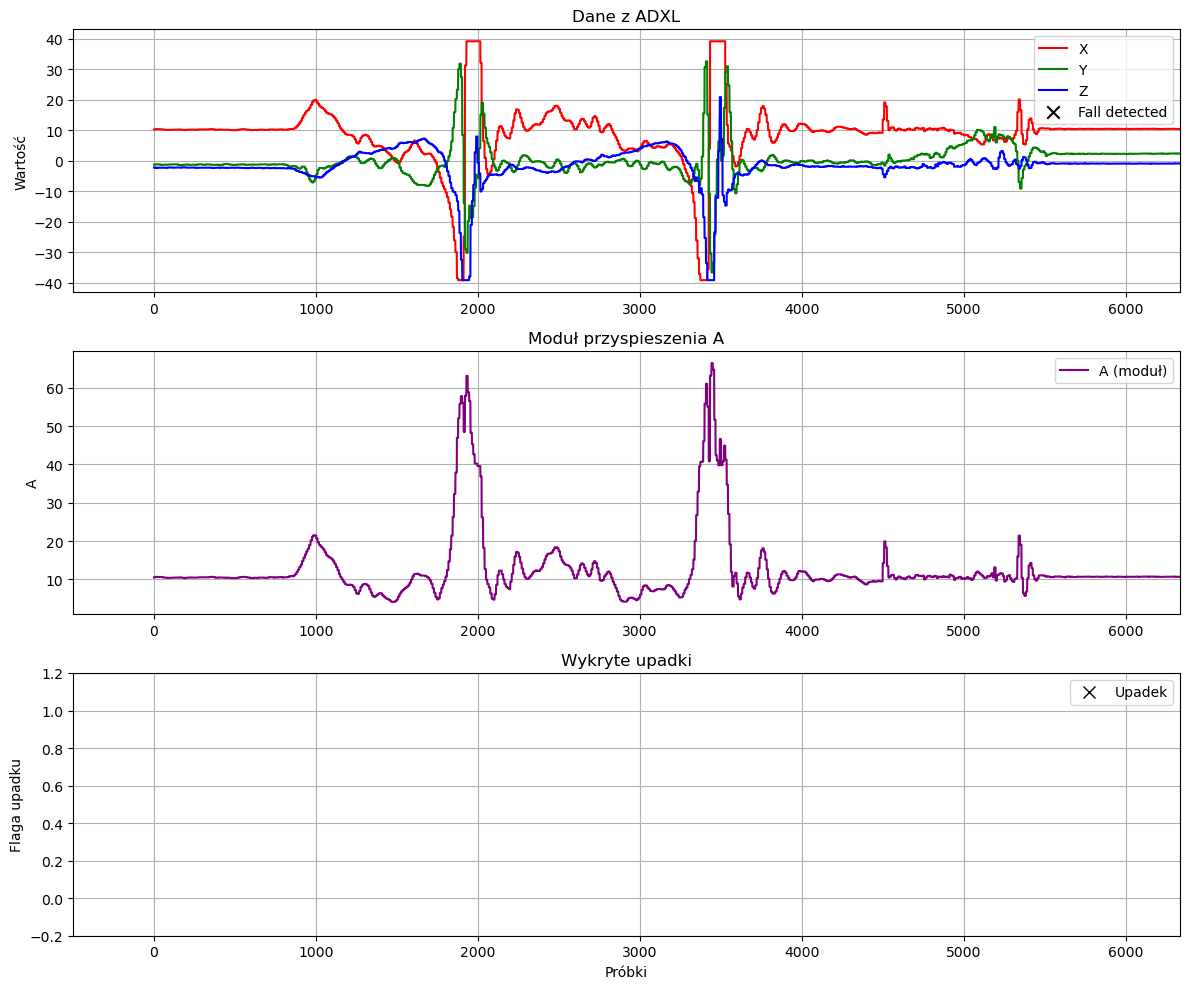

In [ ]:
df["A"] = np.sqrt(df["X"]**2 + df["Y"]**2 + df["Z"]**2)

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(df['X'], label='X', color='red')
plt.plot(df['Y'], label='Y', color='green')
plt.plot(df['Z'], label='Z', color='blue')

fall_indices = df.index[df['FALL'] == 1]
plt.scatter(fall_indices, df.loc[fall_indices, 'X'], color='black', marker='x', s=80, label='Fall detected')
plt.scatter(fall_indices, df.loc[fall_indices, 'Y'], color='black', marker='x', s=80)
plt.scatter(fall_indices, df.loc[fall_indices, 'Z'], color='black', marker='x', s=80)

plt.title('Dane z ADXL')
plt.xlim(-500, len(df))
plt.ylabel('Wartość')
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(df["A"], label="A (moduł)", color="purple")
plt.scatter(fall_indices, df.loc[fall_indices, 'A'], color='black', marker='x', s=80)
plt.title("Moduł przyspieszenia A")
plt.xlim(-500, len(df))
plt.ylabel("A")
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(fall_indices, [1]*len(fall_indices), 'kx', markersize=8, label="Upadek")
plt.title("Wykryte upadki")
plt.xlabel("Próbki")
plt.ylabel("Flaga upadku")
plt.xlim(-500, len(df))
plt.ylim(-0.2, 1.2)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Implementacja modelu uczenia maszynowego do detekcji upadku

In [ ]:
#Dodatkowe cechy będące wejściem do modelu ML
df["A"] = np.sqrt(df["X"]**2 + df["Y"]**2 + df["Z"]**2)
df["DX"] = df["X"].diff().fillna(0)
df["DY"] = df["Y"].diff().fillna(0)
df["DZ"] = df["Z"].diff().fillna(0)
df["DA"] = df["A"].diff().fillna(0)
df.to_csv("data/train_features.csv", index=False)
df.head()

,X,Y,Z,FALL,A,DX,DY,DZ,DA
0,10.1,2.45,2.91,0,10.792618,0.0,0.0,0.0,0.0
1,10.1,2.45,2.91,0,10.792618,0.0,0.0,0.0,0.0
2,10.1,2.45,2.91,0,10.792618,0.0,0.0,0.0,0.0
3,10.1,2.45,2.91,0,10.792618,0.0,0.0,0.0,0.0
4,10.1,2.45,2.91,0,10.792618,0.0,0.0,0.0,0.0


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

df = pd.read_csv("data/train_features.csv")

def extract_features(window):
    features = {}
    for col in ["X", "Y", "Z", "A", "DX", "DY", "DZ", "DA"]:
        data = window[col]
        features[f"{col}_mean"] = data.mean()
        features[f"{col}_std"] = data.std()
        features[f"{col}_min"] = data.min()
        features[f"{col}_max"] = data.max()
        features[f"{col}_range"] = data.max() - data.min()
        features[f"{col}_energy"] = np.sum(data**2)
    features["FALL"] = window["FALL"].max()
    return features

window_size = 160
step_size = 80 

windows = []
for start in range(0, len(df) - window_size, step_size):
    window = df.iloc[start:start+window_size]
    windows.append(extract_features(window))

data = pd.DataFrame(windows)

X = data.drop("FALL", axis=1)
y = data["FALL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Trenowanie modeli
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBClassifier(n_estimators=200, scale_pos_weight=(len(y_train)/y_train.sum()), use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

print("\nXGBoost")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=3))

joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')

c:\Users\szymo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:48:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random Forest
[[107   0]
 [  0   4]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       107
           1      1.000     1.000     1.000         4

    accuracy                          1.000       111
   macro avg      1.000     1.000     1.000       111
weighted avg      1.000     1.000     1.000       111


XGBoost
[[107   0]
 [  0   4]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       107
           1      1.000     1.000     1.000         4

    accuracy                          1.000       111
   macro avg      1.000     1.000     1.000       111
weighted avg      1.000     1.000     1.000       111



['xgb_model.pkl']

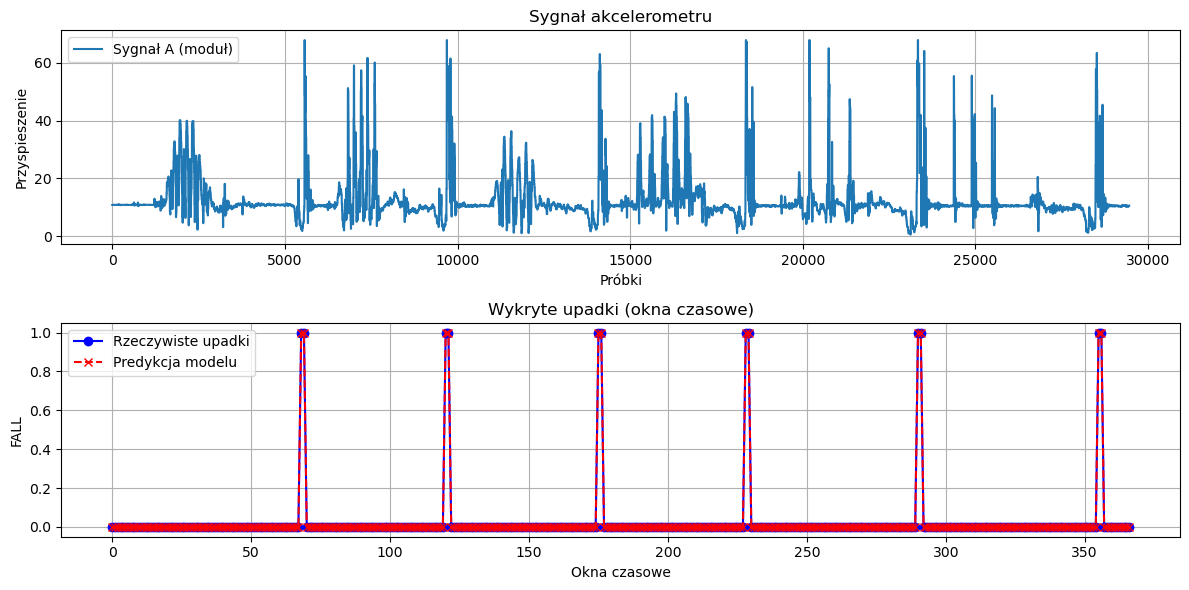

In [58]:
import matplotlib.pyplot as plt

X_all = data.drop("FALL", axis=1)
y_all = data["FALL"]

y_pred_all = rf.predict(X_all)   # xgb.predict(X_all)

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df.index, df["A"], label="Sygnał A (moduł)")
plt.title("Sygnał akcelerometru")
plt.xlabel("Próbki")
plt.ylabel("Przyspieszenie")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(data.index, y_all, "bo-", label="Rzeczywiste upadki")
plt.plot(data.index, y_pred_all, "rx--", label="Predykcja modelu")
plt.title("Wykryte upadki (okna czasowe)")
plt.xlabel("Okna czasowe")
plt.ylabel("FALL")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Sygnał rzeczywisty z użyciem ML

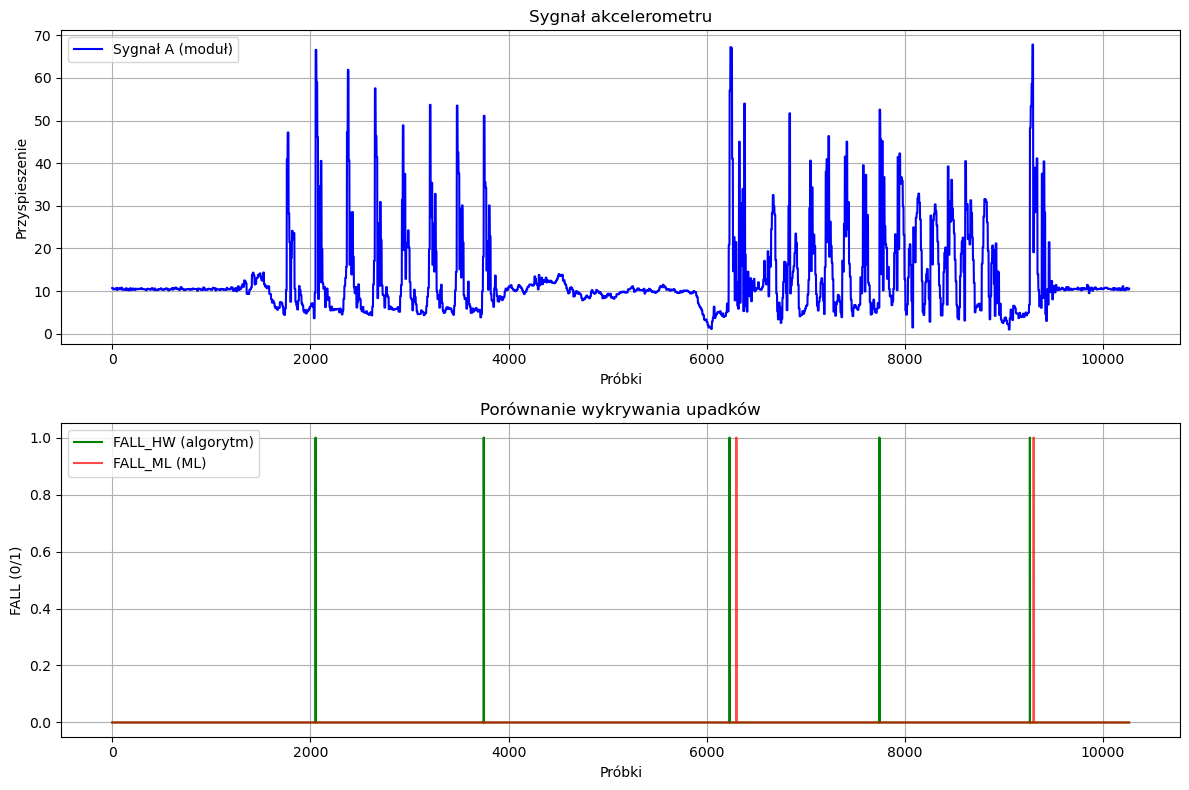

In [60]:
df = pd.read_csv("data/dane.csv")

df["A"] = np.sqrt(df["X"]**2 + df["Y"]**2 + df["Z"]**2)
df["FALL_ML"] = df["FALL_ML"].fillna(0)

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(df.index, df["A"], label="Sygnał A (moduł)", color="blue")
plt.title("Sygnał akcelerometru")
plt.xlabel("Próbki")
plt.ylabel("Przyspieszenie")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(df.index, df["FALL_HW"], label="FALL_HW (algorytm)", drawstyle="steps-post", color="green")
plt.plot(df.index, df["FALL_ML"], label="FALL_ML (ML)", drawstyle="steps-post", color="red", alpha=0.7)
plt.title("Porównanie wykrywania upadków")
plt.xlabel("Próbki")
plt.ylabel("FALL (0/1)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()